# Frequency Correction

In this notebook, we will show how the `Suspect` toolbox can be used to correct for B0 frequency drift in a raw data signal. Typically, to increse the SNR of single voxel 1D MR spectra, multiple sequential repetitions of the scan are acquired, and then averaged. If the background noise in the signal is white Gaussian, its contribution to the averaged signal power should decrease as `1//N`, where `N` is the total number of signals used to compute the average. More scans = more SNR! Well...maybe not. If there has been drift in the B0 frequency across the repetitions of the scans, simply averaging them together without first correcting for the drift can result in significant peak broadening in the 1D signal. Subsequent quantitation of metabolite concentrations based on these signals could be inaccurate - however, without assessment of the raw signals prior to averaging, any frequency drift that occurred during acquisition may be obscured. 

In the following, we will show how the modules in the `Suspect` toolbox can be used to:

1. Inspect raw TWIX data, and identify if significant drift in B0 frequency is present

2. Correct for the drift using two different methods
  1. Simple alignment to a reference peak
  2. Alignment using spectral registration

As always, we start by importing the modules we are going to need.

In [1]:
import sys
# Put the dev version of the toolbox at the head of the path
sys.path.insert(1,'/Users/lauramariano/Documents/mrs/openmrslab/openmrslab')
sys.path.insert(1,'/Users/lauramariano/Documents/mrs/openmrslab/suspect')

import suspect
import numpy as np
import suspect.viz.plot_1D_signals as plot_sigs
from matplotlib import pyplot
# tell jupyter that we want all plots to be shown in the document
%matplotlib inline


For this example, we'll process a Siemens TWIX data file. TWIX is a raw data format which gives us access to the data from each individual channel and repetition. The files can be loaded using the `load_twix` function in `Suspect's io` module. The datasets were collected in vivo from a PCG voxel in the brain, with and without H2O suppression.

In [2]:
# with H2O suppression
data = suspect.io.load_twix('/Users/lauramariano/Documents/mrs/sample_data/sample_data/example_frequency_correction.dat')

# Unsupressed H2O reference scan
data_wref = suspect.io.load_twix('/Users/lauramariano/Documents/mrs/sample_data/sample_data/example_frequency_correction_wref.dat')

`data` and `data_wref` are are instances of the `MRSData` class, which is a subclass of `numpy.ndarray` that adds MRS specific properties and methods, so that we can, for example find out the Larmor frequency of the scanner, or the echo time of the data.

In [3]:
data.f0

123.26176799999999

In [4]:
data.te

30

The dimensions of `data` and `data_wref` are:

In [5]:
[nreps,ncoils,npoint] = data.shape
print(data.shape)
print(data_wref.shape)

(128, 32, 2048)
(128, 32, 2048)


When we look at the shape of the data object, we see that it has three dimensions. The last dimension is the ADC values acquired during readout. The middle dimension is the data from the individual coils of the 32 channel head coil used to acquire this dataset, and the first dimension is the number of repetitions performed. In this case, the unsuppressed H2O signal has 16 scans, while the H2O suppressed acquisition was repeated 128 times. Other types of data may have different numbers of dimensions: CSI datasets have 2 or 3 spatial components, MEGAPRESS sequences have an on/off dimension and COSY/JPRESS have an increment component.

### Inspecting the raw MRS data

The data in this file is from a single voxel PRESS acquisition which is signficantly affected by a drift in the B0 frequency. The extent of the drift can be assessed visually by plotting the raw data with the plotting functions in the `viz.plot_1D_signals` module.


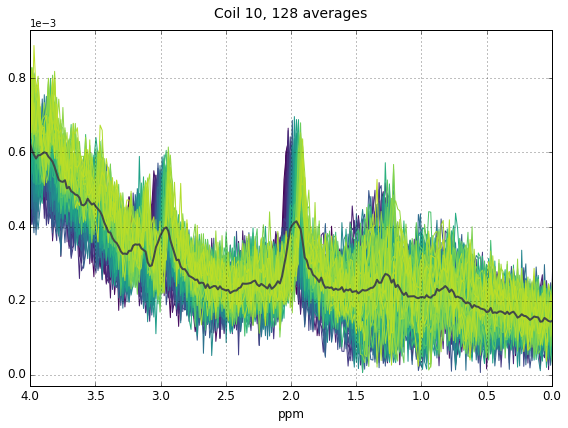

In [6]:
# Identify a good channel to use for visualizing the raw data
coil_idx,_ = plot_sigs.suggest_channel(data.spectrum())

# Extract just this slice of the data for plotting
spectra = data.spectrum()[:,coil_idx,:]

# Plot all averages for this coil on the same axis
# See the plot_1D_sigs notebook for more info about how to use the plotting functions
params = {'xlim':[0,4],'use_colormap':True,'colormap':'viridis','title':'Coil ' + str(coil_idx+1) + ', ' + str(nreps) + ' averages','xlabel':'ppm'}
plot_sigs.plot(data.frequency_axis_ppm(),np.abs(spectra),plot_type='spectra',plot_params = params);

Plotting all the averages collected from a single coil reveals that there has been noticeable drift in the center frequency across averages. The gray line is the average of these repetitions. The drift has significantly widened the peak, which can translate to significant increases in linewidth in the final averaged/coil-combined 1D signal.

In the following, we'll describe a few different methods for automatically correcting for the frequency drift, and assess the impact of these corrections on the quality of the final 1D signal.

### Signal averaging and coil combination

The first step in processing this single voxel data is to combine the signals collected from each of the coils. A standard approach is to first compute the average of all the scan repetitions for each coil, and then compute a weighted average (or sum) of these averages aross the coils. Coil weights are typically chosen to be proportional to the SNR of each coil, which can be computed from the unsuppressed H2O reference signal if it is availble.  There are many methods for doing this described in the literature. For this example, we'll be using the SVD coil weighting method, described in [1], which is implemented in the `processing.channel_combination` module. For a more in-depth discussion of additional coil-combination methods, please see the `Coil Combination` notebook.

#### Coil combination with the SVD algorithm

Since we have unsupressed H2O signals available to us, we can use them to compute the coil weights using the SVD algorithm, and then apply these weights to the H2O suppressed dataset. The implementation of the SVD method we'll use for this example is described in [1], for the case where all of the scans from each of the coils is available, as in the case of TWIX data. 

(128, 2048)


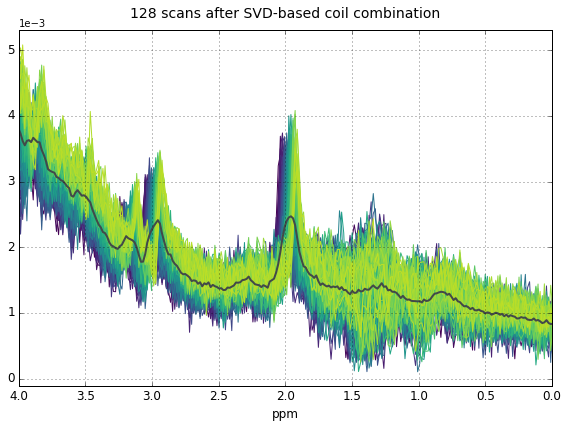

In [7]:
# Use the wref signal to determine coil weights
# Input the raw 3D wref data to the svd_weighting module. Note that the expected dimensions are [n_reps x n_chans x n_points]
channel_weights,combined_fids_wref = suspect.processing.channel_combination.svd_weighting(data_wref);

# Apply to the H2O suppressed data
# Note that we have to apply the weights along axis 1 for this case
combined_fids = suspect.processing.channel_combination.apply_weights(data,channel_weights,ax=1)
combined_data_no_ave = data.inherit(combined_fids)

print(combined_fids.shape)

# Plot the result
params = {'xlim':[0,4],'xlabel':'ppm','title':'128 scans after SVD-based coil combination','use_colormap':True,'colormap':'viridis'}
plot_sigs.plot(data.frequency_axis_ppm(),np.abs(combined_data_no_ave.spectrum()),plot_type='spectra',plot_params = params);

Note the shape of the combined FIDs at this point. It is [n_reps x n_points]. The individual scans from each coil have been weighted using the coil weights derived from the unsuppressed H2O signal.

This plot looks kind of like the one in the previous example, where all the averages for a single coil were plotted on the same axis. The difference is that now we've already performed the coil combination, and have a set of 128 signals with higher SNR and visible peaks in the [0,4] ppm region, which we can use to test out multiple alignment algorithms. The end goal is to align these repetitions with each other so that they can be averaged coherently, producing a 1D signal with increased SNR.

## Fixing the drift

It took quite a few steps to get here, but we're finally going to get into the actual purpose of this notebook - exploring methods for fixing frequency drift post-hoc.  Thanks for hanging in there!

There are a lot of methods described in the literature for addressing the B0 drift problem. In this notebook, we are going to describe two of them:

1. Simple alignment to residual H2O peak
2. Spectral registration, as described in [2]

### Alignment to residual H2O peak

If after H2O suppression there remains a significant, well-behaved residual (frequency domain) H2O peak in the signal, simply using this peak as an anchor point to align the ensemble of signals is a pretty straightforward and easy to implement approach. The dataset we have been working with is a good example of this.


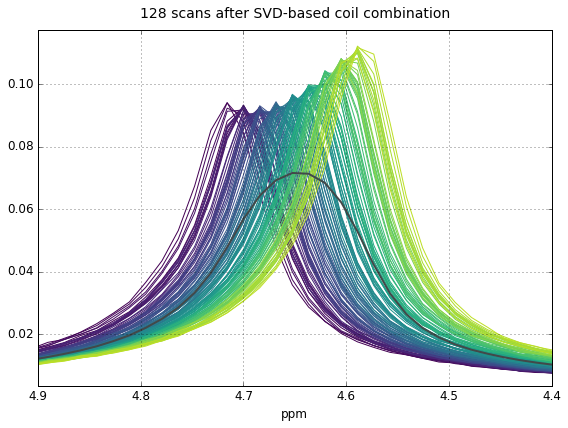

In [8]:
# Look at the scans in the region of the unsuppressed H2O peak
# update xlimits of the parameter dictionary. All the other parameters can stay the same
params['xlim'] = [4.4,4.9]
plot_sigs.plot(data.frequency_axis_ppm(),np.abs(combined_data_no_ave.spectrum()),plot_type='spectra',plot_params = params);

This is a pretty extreme case of signal drift, but a good candidate for the simple H2O alignment method to give good results.

The `processing.frequency_correction` module has a method called `peak_alignment` that provides a simple algorithm for aligning an ensemble of signals to the peak value of a reference signal. It simply shifts each signal to the left or right until its peak aligns with the reference peak. As such, it works best with the frequency domain representation of the data. 

The function requires that you specify a few input parameters:

1. Upper and lower bounds to use to search for the peak in each signal
2. Index of the signal to use as the reference
3. Type of the data to use for the alignment (i.e. abs, real, imag)
4. Type of padding to use for the beginning/end of each signal if it has to be shifted to align with the reference

The example below applies the `peak_alignment` method to `combined_data_no_ave`, which contains the ensemble of averages after coil combination with the SVD algorithm. Note that the alignment uses Hz instead of ppm, so the B0 drift can be quantified in these terms.

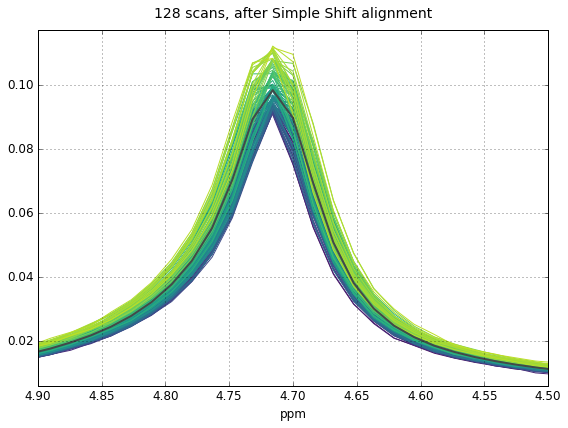

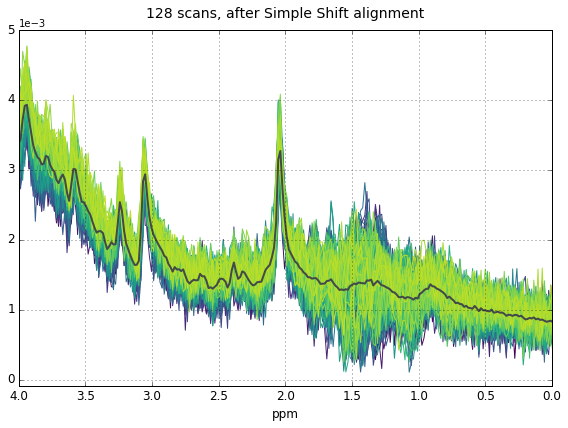

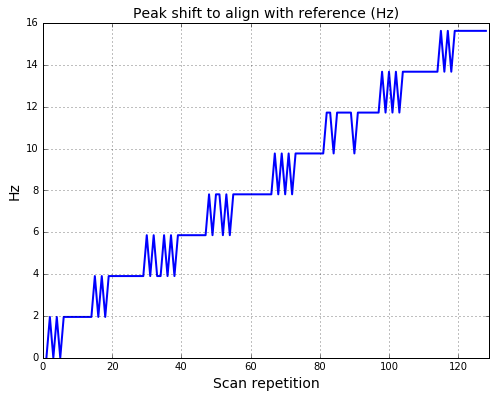

In [9]:
# Use the following input parameters
# window = [-30,30]: Hz range to use for locating the peaks
# ref_idx = 0: Use the first signal in the array as the reference
# max_type = 'abs': Use the magnitude of the signal to identify peaks
# pad_with = 'replicate': If a signal has to be shifted to the left/right to align with the reference, pad the beginning/end replicas of the first/last data points

aligned_data_fd, peak_deltas = suspect.processing.frequency_correction.peak_alignment(data.frequency_axis(),
                                                                                      combined_data_no_ave.spectrum(),
                                                                                      [-30,30], ref_idx=0, max_type='abs', pad_with = 'replicate');

# Plot the results a couple of different ways
params['title'] = '128 scans, after Simple Shift alignment'

# In the region around the residual H2O peak 
params['xlim'] = [4.5,4.9] 
plot_sigs.plot(data.frequency_axis_ppm(),np.abs(aligned_data_fd),plot_type='spectra',plot_params = params);

# In the metabolite region
params['xlim'] = [0,4]
plot_sigs.plot(data.frequency_axis_ppm(),np.abs(aligned_data_fd),plot_type='spectra',plot_params = params);

# Plot the ppm shift required to align all of the averages to the reference signal
# Create a new figure
pyplot.figure(figsize=(8,6))
pyplot.plot(range(1,len(peak_deltas)+1),peak_deltas,linewidth=2);
pyplot.xlim([0,len(peak_deltas)+1]);
pyplot.grid('on')
pyplot.xlabel('Scan repetition',fontsize=14)
pyplot.ylabel('Hz',fontsize=14)
pyplot.title('Peak shift to align with reference (Hz)',fontsize=14);

The first and second plots depict the ensemble of signals in the region around the residual H2O peak, and in the 0-4 ppm region after simple shift alignment. The ensemble average, overlaid on both plots, shows a peak with a much narrower linewidth compared to the non-aligned ensemble.

The third plot depicts the amount of drift observed in each of the scan repetitions, relative to the reference signal, which was the first acquisition in this case. For this dataset, by the 128th repetition, the peak frequency of the residual H2O peak has drifted about 16 Hz from where it started.

Plotting the before and after:

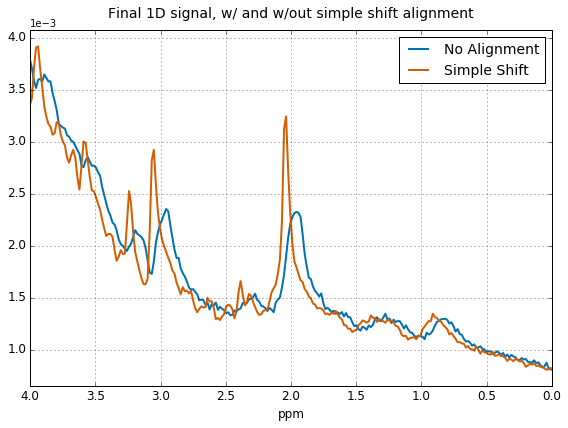

In [10]:
# Take the average of the datasets
mean_no_align = np.average(combined_data_no_ave.spectrum(),axis=0)
mean_simp_shift = np.average(aligned_data_fd,axis=0)

# Plot them on the same axis
shift_compare = np.abs(np.vstack((mean_no_align,mean_simp_shift)))
params = {'xlim':[0,4],'xlabel':'ppm','title':'Final 1D signal, w/ and w/out simple shift alignment'}
_, _, line_handles = plot_sigs.plot(data.frequency_axis_ppm(),shift_compare,plot_type='spectrum',plot_params = params);
leg_handle = pyplot.legend(line_handles,['No Alignment','Simple Shift'],fontsize=14);

A huge decrease in linewidth!

## Frequency correction with spectral registration

The previous example described a simple method for compensating for B0 drift using the magnitude of the frequency domain representation of the data and the residual H2O peak. 

Another recently developed approach for frequency correction is a method called spectral registration, described in [2]. This method uses a least squares optimization to identify frequency and phase shift parameters that best fit each signal to a reference, in the time domain. There is an exellent Matlab-based implementation of this method provided by its authors, available for download here:

https://github.com/CIC-methods/FID-A

The `Suspect` toolbox provides a Python-based implementation of this method. In this example, we'll describe how to use this function, and compare the results to the simple shift method.

First, let's just run the spectral registration algorithm with default parameters on `combined_data_no_ave`. (Note that this function requires that the input data be an `MRSData` object).

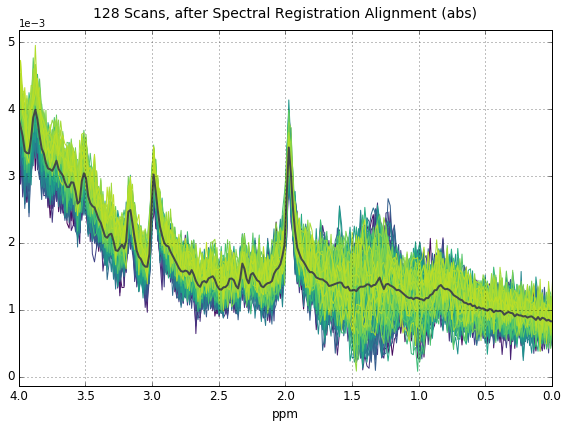

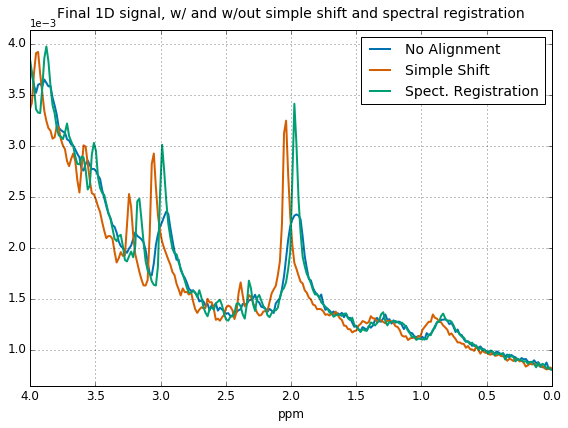

In [11]:
# Run the spectral registration function with default parameters
# Make sure the input data is actually an MRSData object, not just the bare ndarray
aligned_data_spect_reg, target, opt_params = suspect.processing.frequency_correction.spectral_registration(combined_data_no_ave)

# Plot the results!
# Make some changes to the plotting parameters
params.update({'title':'128 Scans, after Spectral Registration Alignment (abs)','use_colormap':True,'colormap':'viridis'})
plot_sigs.plot(aligned_data_spect_reg.frequency_axis_ppm(),np.abs(aligned_data_spect_reg.spectrum()),plot_type='spectra',plot_params = params);

# Compare results to the un-aligned data, and to the simple shift method
mean_spect_reg = np.average(aligned_data_spect_reg.spectrum(),axis=0)
shift_compare = np.abs(np.vstack((mean_no_align,mean_simp_shift,mean_spect_reg)))


params = {'xlim':[0,4],'xlabel':'ppm','title':'Final 1D signal, w/ and w/out simple shift and spectral registration','use_colormap':False}

_, _, line_handles = plot_sigs.plot(data.frequency_axis_ppm(),shift_compare,plot_type='spectrum',plot_params = params);
# Add a legend
leg_handle = pyplot.legend(line_handles,['No Alignment','Simple Shift','Spect. Registration'],fontsize=14);


Comparing linewidths of the final averaged signal, the spectral registration method seems to have done a better job at compensating for the misalignment than the simple shift method for this particular dataset.



Using the default configuration of the `spectral_registration` function automatically selects a target signal to use as a reference from the ensemble, and considers the entire frequency range when performing the optimization. The function also has several other optional input parameters, including specification of a subset of the spectra to use for alignment (in ppm), and alternative ways to define the target signal used for optimization. See the documentation for a more complete description of these options.

## Conclusions

Center frequency drift across repeated acquisitons may or may not be present, and may be negligible or significant. If the raw data (prior to averaging and coil combination) is available, it's probably a good idea to check for this.  The two frequency drift correction methods described in this notebook (simple shift, and spectral registration), are by no means the only (or best!) methods for solving this problem. Additionally, depending on your dataset, one approach might work better than another, or may require specification of different parameters. Either way, it's probably not a bad idea to experiment with adding a B0 drift correction step to the processing pipeline.

## References

[1] Rodgers, Christopher T., and Matthew D. Robson. "Receive array magnetic resonance spectroscopy: whitened singular value decomposition (WSVD) gives optimal Bayesian solution." Magnetic resonance in medicine 63.4 (2010): 881-891.

[2] Near, Jamie, et al. "Frequency and phase drift correction of magnetic resonance spectroscopy data by spectral registration in the time domain." Magnetic resonance in medicine 73.1 (2015): 44-50.